In [1]:
import pandas as pd
import time
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
# https://docs.tweepy.org/en/stable/client.html
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)
from pathlib import Path
import networkx as nx

# Data preprocessing

For each csv (one day = 1 csv) in the dataset folder:

    * filter to only keep english
    * only keep userid, tweetid, text, hashtags columns
    * delete duplicate based on test
    * sample 15k per day (for a total of around 200k for 2 weeks)
    * save the new df in the csvdataframes folder as day_{idx}.csv

In [2]:
# Preprocessing the datasets and save them in csv files under csvdataframes folder
print("Creating folders")
Path.mkdir(Path("csvdataframes"), exist_ok=True)
Path.mkdir(Path("edgelists"), exist_ok=True)
Path.mkdir(Path("csvdataframes_wOgIds"), exist_ok=True)

Creating folders


In [3]:
print("Preprocessing the data")
for idx, day in enumerate(Path("dataset").iterdir()):
    full_dataset = pd.read_csv(day, compression='gzip')
    df_en = full_dataset[full_dataset['language']=='en']
    df_en_filteted = df_en[["userid", "tweetid", "text", "hashtags"]]
    df_no_duplicate = df_en_filteted.drop_duplicates(subset='text', keep='first')
    df_sampled = df_no_duplicate.sample(5)
    df_sampled.to_csv(Path("csvdataframes") / f"day_{idx}.csv")
    print(".", end='', flush=True)

Preprocessing the data
.

/tmp/ipykernel_12398/308354048.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataset = pd.read_csv(day, compression='gzip')


.

Because the original dataset contains retweet id, for each df in the
csvdataframes folder add a new columns original_tweet_id with value the
original tweet id if the tweet was a retweet else keep the tweet id and save
every thing on the csvdataframes_wOgIds folder

In [4]:
def get_tweets(ids):
    tweets = client.get_tweets(ids=ids, expansions=['referenced_tweets.id', 'referenced_tweets.id.author_id'])
    return tweets

def get_original_tweets_ids(ids):
    # convert ids to list
    ids_list = ids["tweetid"].tolist()
    tweets = get_tweets(ids_list)
    # create df with columns original_tweet_id and author_id
    return_df = pd.DataFrame(columns=["author_id", "original_tweet_id"])
    if not tweets.data: return None, False
    for tweet in tweets.data:
        referenced_tweet = tweet.get('referenced_tweets')
        original_author = tweet.get('author_id')
        original_tweet_id = referenced_tweet[0].id if referenced_tweet else tweet.id
        # concat to df
        return_df = pd.concat([return_df, pd.DataFrame({"author_id": [original_author], "original_tweet_id": [original_tweet_id]})], ignore_index=True)
    return_df['Unnamed: 0'] = ids['Unnamed: 0']
    return return_df, True

In [5]:
for idx, file in enumerate(Path("csvdataframes").iterdir()):
    print(file)
    df = pd.read_csv(file)
    # temp df to store original tweet ids
    temp_df = pd.DataFrame()
    # split df by 100 
    for i in range(0, len(df), 100):
        print(f"{file} Iteration {i}-{i+100} / {len(df)}")
        df_100 = df[i:i+100]
        original_tweet_ids_df, empty_check = get_original_tweets_ids(df_100)
        if not empty_check: continue
        # concat temp_df and original_tweet_ids_df
        temp_df = pd.concat([temp_df, original_tweet_ids_df], ignore_index=True)
    # Merge temp_df with df
    if temp_df.empty: continue
    df = pd.merge(df, temp_df, on="Unnamed: 0")
    # save df to csv
    df.to_csv(Path(f"csvdataframes_wOgIds/day_{idx}.csv"), index=False)


csvdataframes/day_1.csv
csvdataframes/day_1.csv Iteration 0-100 / 5
csvdataframes/day_0.csv
csvdataframes/day_0.csv Iteration 0-100 / 5


# Edge list creation

In [6]:
# get_retweeters from 1 id and 1 pagination token
def get_retweeters(id, pagination_token=None):
    print(".", end='', flush=True)
    retweeters = client.get_retweeters(id, pagination_token=pagination_token)
    next_token = retweeters.meta.get('next_token')

    if not retweeters.data:
        return None, None

    # return list of user ids
    retweeter_ids = [retweeter.id for retweeter in retweeters.data]
    return retweeter_ids, next_token

# get_all_retweeters from 1 id
def get_all_retweeters(id):
    retweeter_ids = []
    next_token = None
    while True:
        retweeter_ids_, next_token = get_retweeters(id, pagination_token=next_token)
        if retweeter_ids_ is None:
            break
        retweeter_ids += retweeter_ids_
    return retweeter_ids

In [7]:
def get_linkin_users(id, pagination_token=None):
    print(".", end='', flush=True)
    retweeters = client.get_liking_users(id, pagination_token=pagination_token)
    next_token = retweeters.meta.get('next_token')

    if not retweeters.data:
        return None, None

    # return list of user ids
    retweeter_ids = [retweeter.id for retweeter in retweeters.data]
    return retweeter_ids, next_token

def get_all_linkin_users(id):
    retweeter_ids = []
    next_token = None
    while True:
        retweeter_ids_, next_token = get_linkin_users(id, pagination_token=next_token)
        if retweeter_ids_ is None:
            break
        retweeter_ids += retweeter_ids_
    return retweeter_ids

In [8]:
def create_retweeters_edgelist():
    # read csv files from csvdataframes_wOgIds folder
    for idx, file in enumerate(Path("csvdataframes_wOgIds").iterdir()):
        # create empty edgelists df with column retweeter_id and tweet_id
        edgelists_df = pd.DataFrame(columns=["user_id", "author_id"])
        print(file)
        df = pd.read_csv(file)
        
        for tweetId, author_id in zip(df['original_tweet_id'], df['author_id']):
            print(tweetId, end='')
            retweeter_ids = get_all_retweeters(tweetId)
            # convert to df
            retweeter_ids_df = pd.DataFrame(retweeter_ids, columns=["user_id"])
            # add tweetId to df
            retweeter_ids_df.insert(1, "author_id", author_id)
            # concat edgelists_df and retweeter_ids_df
            edgelists_df = pd.concat([edgelists_df, retweeter_ids_df], ignore_index=True)
            print("Done")
        # save df to csv
        edgelists_df.to_csv(Path(f"edgelists/retweeters_{idx}.csv"), index=False)

    # # save edgelists_df to csv
    # edgelists_df.to_csv(Path(f"edgelists/retweeters.csv"), index=False)

    # return edgelists_df

    
def create_liking_edgelist():
    # read csv files from csvdataframes_wOgIds folder
    for idx, file in enumerate(Path("csvdataframes_wOgIds").iterdir()):
         # create empty edgelists df with column liker_id and tweet_id
        edgelists_df = pd.DataFrame(columns=["user_id", "author_id"])
        print(file)
        df = pd.read_csv(file)
        for tweetId, author_id in zip(df['original_tweet_id'], df['author_id']):
            print(tweetId, end='')
            liker_ids = get_all_linkin_users(tweetId)
            # convert to df
            liker_ids_df = pd.DataFrame(liker_ids, columns=["user_id"])
            # add tweetId to df
            liker_ids_df.insert(1, "author_id", author_id)
            # concat edgelists_df and liker_ids_df
            edgelists_df = pd.concat([edgelists_df, liker_ids_df], ignore_index=True)
            print("Done")
        # save df to csv
        edgelists_df.to_csv(Path(f"edgelists/liking_{idx}.csv"), index=False)

    # # save edgelists_df to csv
    # edgelists_df.to_csv(Path(f"edgelists/liking.csv"), index=False)

    # return edgelists_df

In [9]:
create_retweeters_edgelist()
create_liking_edgelist()

csvdataframes_wOgIds/day_1.csv
1501112791436251138.

Rate limit exceeded. Sleeping for 27 seconds.


.Done
1501253904574472197.Done
1501282376520912904..Done
1501144246337908740.Done
1501013353128464385..Done
csvdataframes_wOgIds/day_0.csv
1499728774212067333..Done
1499575579716243465...........................Done
1499618122839781376.Done
1499877369598787585..Done
1499755795503665157..Done
csvdataframes_wOgIds/day_1.csv
1501112791436251138.Done
1501253904574472197.Done
1501282376520912904..Done
1501144246337908740..Done
1501013353128464385..Done
csvdataframes_wOgIds/day_0.csv
1499728774212067333..Done
1499575579716243465.............................Done
1499618122839781376.Done
1499877369598787585..Done
1499755795503665157..Done


# First viz & basic stats

In [10]:
# load edgelists retweeters and liking from csv files to edgelists_df dataframe 
edgelists_retweeters_df = pd.read_csv(Path(f"edgelists/retweeters_0.csv"))
edgelists_likers_df = pd.read_csv(Path(f"edgelists/liking_0.csv"))

In [11]:
edgelists_likers_df

,user_id,author_id
0,4495340234,1149557758053605376
1,1088459680714711040,1149557758053605376
2,2563475775,1149557758053605376
3,1438910068238401538,1149557758053605376
4,3142845018,1149557758053605376
5,1445093406645096456,1149557758053605376
6,1400195736948527106,1149557758053605376
7,1388138590912139273,1149557758053605376
8,113557572,1149557758053605376
9,916519317780316160,1149557758053605376


In [12]:
# print number of unique users in edgelists_likers_df
print(len(edgelists_likers_df['user_id'].unique()))

# print number of unique author in edgelists_likers_df
print(len(edgelists_likers_df['author_id'].unique()))

50
3


In [13]:
# concat edgelists_likers_df and edgelists_retweeters_df
edgelists_df = pd.concat([edgelists_likers_df, edgelists_retweeters_df], ignore_index=True)

edgelists_df

,user_id,author_id
0,4495340234,1149557758053605376
1,1088459680714711040,1149557758053605376
2,2563475775,1149557758053605376
3,1438910068238401538,1149557758053605376
4,3142845018,1149557758053605376
...,...,...
118,70331587,1149557758053605376
119,817817248689754113,1149557758053605376
120,1065277975019417601,1149557758053605376
121,1319767887167578114,1319767887167578114


In [14]:
# print number of unique users in edgelists_df
print(len(edgelists_df['user_id'].unique()))

# print number of unique author in edgelists_df
print(len(edgelists_df['author_id'].unique()))

118
4


In [15]:
# drop duplicates in edgelists_df
edgelists_df.drop_duplicates(inplace=True)

edgelists_df

,user_id,author_id
0,4495340234,1149557758053605376
1,1088459680714711040,1149557758053605376
2,2563475775,1149557758053605376
3,1438910068238401538,1149557758053605376
4,3142845018,1149557758053605376
...,...,...
113,1499443706692358144,1483743771879690245
114,1494037874886561796,1483743771879690245
115,1466450824318574595,1483743771879690245
116,1431333358529826820,1483743771879690245


In [16]:
# load edgelists_df to networkx graph
edgelists_graph = nx.from_pandas_edgelist(edgelists_df, source='user_id', target='author_id')

# print number of nodes in edgelists_graph
print(len(edgelists_graph.nodes))

# print number of edges in edgelists_graph
print(len(edgelists_graph.edges))

120
118


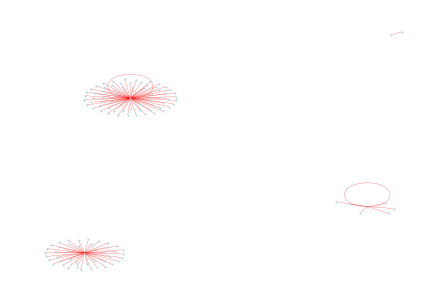

In [17]:
# draw edgelists_graph
# node color light blue
# edge color light blue
# node size proportional to degree
# edge width proportional to weight
# node labels hidden
# edge labels hidden
nx.draw(edgelists_graph, node_color='lightblue', edge_color='red', node_size=1, width=0.2, with_labels=False, labels={})

In [18]:
# load edgelists_retweeters_df and edgelists_likers_df to networkx
G_retweeters = nx.from_pandas_edgelist(edgelists_retweeters_df, source='author_id', target='user_id')
G_likers = nx.from_pandas_edgelist(edgelists_likers_df, source='author_id', target='user_id')

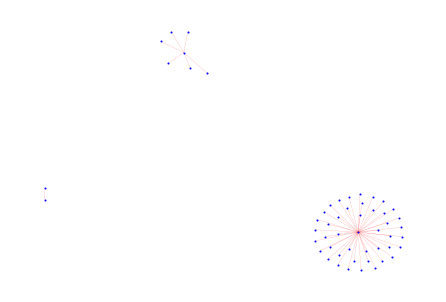

In [19]:
nx.draw(G_likers, with_labels=False, node_size=1, node_color='blue', edge_color='red', width=0.1)

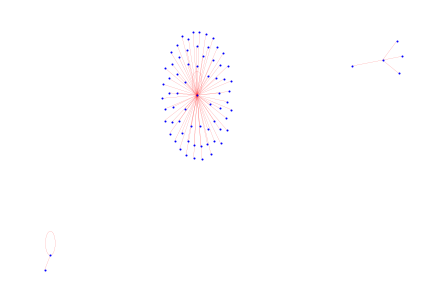

In [20]:
nx.draw(G_retweeters, with_labels=False, node_size=1, node_color='blue', edge_color='red', width=0.1)

In [21]:
# stats of retweeters network 
print(f"Number of nodes: {len(G_retweeters.nodes())}")
print(f"Number of edges: {len(G_retweeters.edges())}")

Number of nodes: 74
Number of edges: 73


In [22]:
# stats of likers network
print(f"Number of nodes: {len(G_likers.nodes())}")
print(f"Number of edges: {len(G_likers.edges())}")

Number of nodes: 53
Number of edges: 50


In [23]:
# clustering coefficient of retweeters network
print(f"Clustering coefficient: {nx.average_clustering(G_retweeters)}")

# clustering coefficient of likers network
print(f"Clustering coefficient: {nx.average_clustering(G_likers)}")

Clustering coefficient: 0.0
Clustering coefficient: 0.0


In [24]:
# average degree of retweeters network
print(f"Average degree: {nx.average_degree_connectivity(G_retweeters)}")

# average degree of likers network
print(f"Average degree: {nx.average_degree_connectivity(G_likers)}")

Average degree: {68: 1.9705882352941178, 1: 63.478873239436616, 4: 1.0, 3: 1.3333333333333333}
Average degree: {43: 1.0, 1: 37.0, 6: 1.0}


# Viz

In [25]:
# read all csv files from edgelists folder and save to edgelists_df
edgelists_df = pd.concat([pd.read_csv(file) for file in Path("edgelists").iterdir()], ignore_index=True)
# drop duplicates in edgelists_df
edgelists_df.drop_duplicates(inplace=True)


3841
3838


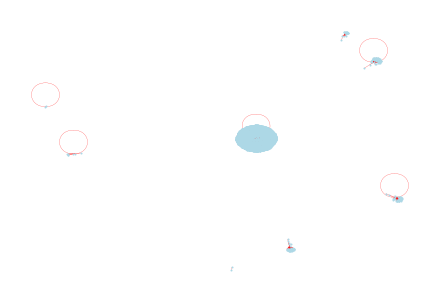

In [26]:
# load edgelists_df to networkx graph
edgelists_graph = nx.from_pandas_edgelist(edgelists_df, source='user_id', target='author_id')

# print number of nodes in edgelists_graph
print(len(edgelists_graph.nodes))

# print number of edges in edgelists_graph
print(len(edgelists_graph.edges))

# draw edgelists_graph
# node color light blue
# edge color red
# node size proportional to degree
# edge width proportional to weight
# node labels hidden
# edge labels hidden
nx.draw(edgelists_graph, node_color='lightblue', edge_color='red', node_size=1, width=0.2, with_labels=False, labels={})